# A. Informationen zum Notebook

<p>Herausgeber: Koordinierungsstelle Bildungsmonitoring (KOSMO)</p>
<p>Version: X.X.X (XX.XX.2023)<p/>
<p>DOI: XXX</p>
<p>Dieses Notebook dient dazu, Gemeindedaten der Bundesagentur fuer Arbeit (BA) mit Bevoelkerungsdaten des Statistischen Bundesamtes (Destatis) zu verknuepfen, um daraus gemeindespezifische SGB-II-Quoten berechnen zu koennen. Hierbei wird auf folgende Originaldaten der BA und von Destatis zugegriffen, die von den entsprechenden Stellen bezogen werden koennen: </p>

- Genaue Zitation BA-Daten
- Genaue Zitation Destatis-Daten

Um die Aufbereitung der Daten korrekt durchfuehren zu koennen, muessen diese Notebook-Datei (.ipynb) sowie die Originaldaten bzw. -dateien der BA und von Destatis in einem lokalen Ordner gespeichert werden.

# 0. Vorbereitung der Daten

In [140]:
# Benoetigte Pakete importieren
import pandas as pd
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Hinweis: die folgende Bibliothek muss manuell installiert werden
from mapclassify import NaturalBreaks
from mapclassify import FisherJenksSampled

In [141]:
# Begrenzung der Spaltendarstellung deaktivieren
pd.set_option("display.max_columns", None)

In [142]:
# Einlesen der Gemeindedaten der Bundesagentur fuer Arbeit (BA) aus den Jahren 2014 bis 2021

# Dateinamen und Tabellennamen abrufen
file_names = [
    ("230328_EA_338634_Gemeindedaten_Teil1.xlsx", "2014"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2015"),
    ("230328_EA_338634_Gemeindedaten_Teil2.xlsx", "2016"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2017"),
    ("230328_EA_338634_Gemeindedaten_Teil3.xlsx", "2018"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2019"),
    ("230328_EA_338634_Gemeindedaten_Teil4.xlsx", "2020"),
    ("230328_EA_338634_Gemeindedaten_Teil5.xlsx", "2021")
]

# Dictionary fuer die Dataframes erstellen
dataframes = {}

# Ueber Dateien und Tabellennamen iterieren
for file_name, sheet_name in file_names:
    # Spezifisches Tabellenblatt in einen DataFrame einlesen
    df = pd.read_excel(file_name, sheet_name=sheet_name)
    # DataFrame im Dictionary speichern
    dataframes["ba_" + sheet_name] = df

# Zugriff auf die Dataframes
ba_2014 = dataframes["ba_2014"]
ba_2015 = dataframes["ba_2015"]
ba_2016 = dataframes["ba_2016"]
ba_2017 = dataframes["ba_2017"]
ba_2018 = dataframes["ba_2018"]
ba_2019 = dataframes["ba_2019"]
ba_2020 = dataframes["ba_2020"]
ba_2021 = dataframes["ba_2021"]

In [143]:
# Daten (Beispiel 2021) inspizieren
ba_2021.head(20)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Grundsicherung für Arbeitsuchende (SGB II)
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Eckwerte der Grundsicherung nach Gemeinden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Deutschland - Gemeinden (Gebietsstand Dezember...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Jahresdurchschnitt 2021, Datenstand: März 2023",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Daten zu Leistungen nach dem SGB II nach einer...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Gemeinde,Leistungs-berechtigte (LB),Insgesamt,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,darunter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,dar. (Sp. 1) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp. 1),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Leistungs-berechtigte (LB),dar. (Sp. 25) im Alter von ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dar. (Sp

# 1. BA-Daten umformen

### 1.1 Grundlegende Umformung der Ausgangsdaten

In [144]:
# Funktion zur Transformation der Daten definieren
def transform_dataframe(df):
    # Zeilen 0 bis 7 entfernen
    df = df.drop(df.index[0:7])
    
    # Letzte Zeile entfernen
    df = df.drop(df.index[-1])
    
    # Spalte 'Unnamed: 0' nach Leerzeichen trennen und in neue Spalten 'AGS' und 'Gemeinde' aufteilen
    df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
    
    # Spalte 'Unnamed: 0' entfernen
    df = df.drop(['Unnamed: 0'], axis=1)
    
    # Erstellen einer Kontrollspalte 'Gesamtwerte_Kontrolle' mit den Spalten 'AGS', 'Gemeinde' und 'Unnamed: 1'
    Gesamtwerte_Kontrolle = df[['AGS', 'Gemeinde', 'Unnamed: 1']].copy()
    
    # Spalte 'Unnamed: 1' entfernen
    df.drop(['Unnamed: 1'], axis=1, inplace=True)
    
    # Nur Spalten ab der 23. Spalte behalten
    df = df.iloc[:, 23:]
    
    # Fehlende Werte in Zeile 5 mit den Werten der vorherigen Zeilen fuellen
    df.iloc[5] = df.iloc[5].fillna(df.iloc[4])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[3])
    df.iloc[5] = df.iloc[5].fillna(df.iloc[2])
    
    # Zeilen 7, 9, 10, 11 und 13 entfernen
    df = df.drop([7, 9, 10, 11, 13])
    
    # Letzte beiden Werte in Zeile 1 mit den Werten der letzten beiden Spaltennamen fuellen
    df.iloc[1, -1] = df.columns[-1]
    df.iloc[1, -2] = df.columns[-2]
    
    # Neue Spaltennamen aus Zeile 1 erstellen
    new_columns = df.iloc[1].tolist()
    
    # Spaltennamen aktualisieren
    df = df.set_axis(new_columns, axis=1, inplace=False)
    
    # Zeile 12 entfernen
    df = df.drop(12)
    
    # Transformiertes DataFrame zurueckgeben
    return df

# Definierte Funktion auf die Daten anwenden und damit Dataframes erstellen
ba_2014 = transform_dataframe(ba_2014)
ba_2015 = transform_dataframe(ba_2015)
ba_2016 = transform_dataframe(ba_2016)
ba_2017 = transform_dataframe(ba_2017)
ba_2018 = transform_dataframe(ba_2018)
ba_2019 = transform_dataframe(ba_2019)
ba_2020 = transform_dataframe(ba_2020)
ba_2021 = transform_dataframe(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecated and will be removed in a future version. Use `obj = obj.set_axis(..., copy=False)` instead
  df = df.set_axis(new_columns, axis=1, inplace=False)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\697503413.py:10: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['AGS', 'Gemeinde']] = df['Unnamed: 0'].str.split(' ', 1, expand=True)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\697503413.py:40: FutureWarning: DataFrame.set_axis 'inplace' keyword is deprecate

In [145]:
# Daten (Beispiel 2018) inspizieren
ba_2018.head()

,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,Leistungs-berechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbs-fähige Leistungs-berechtigte (ELB),erziehende ELB,allein-erziehende ELB,arbeit-suchende ELB insgesamt,kein Hauptschul-abschluss,Hauptschul-abschluss,mittlere Reife,Fachhoch-schule,Abitur/ Hochschul-reife,keine Angabe,ohne abge-schlossene Berufs-ausbildung,betriebliche/schulische Ausbildung,akade-mische Ausbildung,keine Angabe,AGS,Gemeinde
8,Männer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Frauen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,6128.666667,6117.916667,1561.5,378.75,341.166667,841.583333,229.75,741.666667,3585,219.833333,4499,949.25,101,3487.5,707.75,1321.833333,457.583333,210.416667,388.75,401.166667,2415.083333,903.083333,167.333333,2,5643.083333,5631.25,1571.833333,396.25,330.083333,845.5,208,676.666667,3174.75,199.083333,3974,1950.5,1077.666667,2442.583333,416.083333,933.5,396.5,88.75,223.666667,384.083333,1628.666667,724.333333,87.25,2.333333,01001000,"Flensburg, Stadt"
15,17856,17793.5,4702.666667,1010.416667,985.416667,2706.833333,771.916667,1870.083333,10448.833333,742.583333,12939.083333,3024.25,186.916667,9929.666667,2238.25,3303.833333,1309.166667,523.916667,1707.916667,846.583333,6687.333333,2449.666667,789.083333,3.583333,16340.416667,16293.666667,4562.416667,993.833333,930.833333,2637.75,707.083333,1609.75,9414.416667,677.25,11555.5,5476.583333,2516.083333,7028.583333,1520.166667,2319.166667,1166.75,315.666667,1036.666667,670.166667,4652.666667,1829.083333,542.833333,4,01002000,"Kiel, Landeshauptstadt"
16,13417.833333,13344.666667,3785.833333,824.083333,803.75,2158,599.583333,1231.583333,7727.666667,579.583333,9471.166667,2197.916667,163.25,7217.666667,1469.5,2749.333333,961.416667,380.416667,574.75,1082.25,4873.916667,2011.75,329.333333,2.666667,12890,12834.166667,3357.916667,693.25,717.666667,1947,543.416667,1218.5,7714.333333,524.583333,9347.25,4388.666667,2277.583333,5824.166667,1027.833333,2093.083333,1005.916667,252,491.416667,953.916667,3802.25,1756.75,263.333333,1.833333,01003000,"Lübeck, Hansestadt"
17,4778.916667,4760.5,1312.083333,280.666667,284.833333,746.583333,216.833333,506.75,2724.833333,210.25,3358.583333,804,65,2581.916667,605.75,1091.916667,284,77.333333,147.666667,375.25,1870.25,656.75,54.416667,0.5,4680.833333,4658.583333,1295.916667,264.583333,287.666667,743.666667,171,553.25,2638.416667,160.5,3284.25,1630.333333,874.666667,2077.083333,454.083333,889.833333,256.083333,34.416667,98.25,344.416667,1543.5,494.416667,38.333333,0.833333,01004000,"Neumünster, Stadt"


### 1.2 Spalte fuer Geschlecht ergaenzen und Tabelle entsprechend stapeln

In [146]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df):
    # Daten (maennlich) aus den ersten 24 Spalten und den Spalten 48 und 49 extrahieren
    df_m = df.iloc[:, list(range(24)) + [48, 49]]
    
    # Daten (weiblich) aus den Spalten 24 bis 49 extrahieren
    df_w = df.iloc[:, 24:50]
    
    # Geschlecht fuer Daten (weiblich) auf "w" setzen
    df_w.loc[:, "Geschlecht"] = "w"
    
    # Geschlecht fuer Daten (maennlich) auf "m" setzen
    df_m.loc[:, "Geschlecht"] = "m"
    
    # Zeile 8 aus Daten (weiblich) entfernen
    df_w = df_w.drop([8])
    
    # Zeile 8 aus Daten (maennlich) entfernen
    df_m = df_m.drop([8])
    
    # Daten (maennlich und weiblich) zu einem DataFrame kombinieren
    combined_df = df_m.append(df_w, ignore_index=True)
    
    # Spalten umbenennen, indem Bindestriche "-" entfernt werden
    combined_df = combined_df.rename(columns=lambda x: x.replace('-', ''))
    
    return combined_df

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
ba_2014_combined = apply_transformation(ba_2014)
ba_2015_combined = apply_transformation(ba_2015)
ba_2016_combined = apply_transformation(ba_2016)
ba_2017_combined = apply_transformation(ba_2017)
ba_2018_combined = apply_transformation(ba_2018)
ba_2019_combined = apply_transformation(ba_2019)
ba_2020_combined = apply_transformation(ba_2020)
ba_2021_combined = apply_transformation(ba_2021)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\787215793.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_w.loc[:, "Geschlecht"] = "w"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\787215793.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_m.loc[:, "Geschlecht"] = "m"
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\787215793.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat inst

In [147]:
# Daten (Beispiel 2014) inspizieren
ba_2014_combined.head()

,Leistungsberechtigte (LB),unter 65 Jahren,unter 15 Jahren,unter 3 Jahren,3 bis unter 6 Jahren,6 bis unter 15 Jahren,15 bis unter 18 Jahren,18 bis unter 25 Jahren,25 bis unter 65 Jahren,15 bis unter 18 Jahren (Kinder),Erwerbsfähige Leistungsberechtigte (ELB),erziehende ELB,alleinerziehende ELB,arbeitsuchende ELB insgesamt,kein Hauptschulabschluss,Hauptschulabschluss,mittlere Reife,Fachhochschule,Abitur/ Hochschulreife,keine Angabe,ohne abgeschlossene Berufsausbildung,betriebliche/schulische Ausbildung,akademische Ausbildung,keine Angabe,AGS,Gemeinde,Geschlecht
0,5243.25,5236.416667,1198.083333,273.666667,236.833333,687.583333,198.25,576.333333,3263.75,193,3956.25,697.666667,84.75,3215.666667,564.083333,1606.083333,472,174.583333,174,224.916667,1984.5,1101.75,87.75,41.666667,01001000,"Flensburg, Stadt",m
1,16628.916667,16599.75,4059.833333,888.333333,834.25,2337.25,684.75,1519.333333,10335.833333,670.166667,12245.083333,2532.166667,177.166667,9485.75,1735.083333,4051.833333,1469.75,509.5,1110.916667,608.666667,5776.25,3057.75,533.5,118.25,01002000,"Kiel, Landeshauptstadt",m
2,13740.583333,13711.583333,3487,745.166667,707.583333,2034.25,588.916667,1278.916667,8356.75,579.583333,10053.916667,2136.166667,160.166667,7943.333333,1408.916667,3825.75,1176.25,394.5,453.083333,684.833333,4916.416667,2600.833333,241.333333,184.75,01003000,"Lübeck, Hansestadt",m
3,5154.416667,5144.416667,1287.083333,268.833333,241.25,777,242.5,501.333333,3113.5,236.166667,3761.916667,843.333333,78.5,2972.75,653.25,1499.5,339.916667,71.583333,116.833333,291.666667,1914.166667,963.916667,41.75,52.916667,01004000,"Neumünster, Stadt",m
4,198,197,57.666667,17,7.166667,33.5,4.25,18.083333,117,4.25,136.5,27.5,1.166667,110.25,24.083333,60.25,13.083333,2.25,4.416667,6.166667,56.583333,51.5,1.833333,0.333333,01051001,Albersdorf,m


### 1.3 Gestapelte Zieltabellen erstellen:

 - Ein Dataframe (DF) mit Leistungsberechtigten (LB) nach Geschlecht und Altersgruppen, das sich auf Anzahl der LB aggregieren laesst
     - Spalte "LB unter 15 Jahren" loeschen, da aus anderen Spalten summierbar
     - Spalte "LB unter 65 Jahren" loeschen, da aus anderen Spalten summierbar 
     - Spalte "15 bis unter 18 Jahren (Kinder)" loeschen
 - Ein DF mit arbeitssuchenden erwerbsfaehigen Leistungsberechtigten (ELB) nach Geschlecht und Schulabschluessen (Unterscheidung Schulabschluesse nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 15 - 20 in der Ausgangsdatei
 - Ein DF mit arbeitssuchenden ELB nach Geschlecht und Berufsausbildung (Unterscheidung Berufsausbildung nur fuer "arbeitssuchende ELB" moeglich)
     - Spalten 21- 24 in der Ausgangsdatei

In [148]:
print(ba_2014_combined.columns)

Index(['Leistungsberechtigte (LB)', 'unter 65 Jahren', 'unter 15 Jahren',
       'unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren', '15 bis unter 18 Jahren (Kinder)',
       'Erwerbsfähige Leistungsberechtigte (ELB)', 'erziehende ELB',
       'alleinerziehende ELB', 'arbeitsuchende ELB insgesamt',
       'kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife',
       'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe',
       'ohne abgeschlossene Berufsausbildung',
       'betriebliche/schulische Ausbildung', 'akademische Ausbildung',
       'keine Angabe', 'AGS', 'Gemeinde', 'Geschlecht'],
      dtype='object')


In [149]:
# Funktion zur Transformation der Daten definieren
def apply_transformation(df, year):
    # relevante Spalten aus dem kombinierten Dataframe extrahieren
    LB_nach_Altersgruppen = df.iloc[:, [3, 4, 5, 6, 7, 8, 24, 25, 26]].copy()

    # Datensatz in langes Format umwandeln, indem Altersgruppen in separate Spalte transformiert werden
    LB_nach_Altersgruppen = pd.melt(LB_nach_Altersgruppen, id_vars=['AGS', 'Gemeinde', 'Geschlecht'], value_vars=['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren', '15 bis unter 18 Jahren', '18 bis unter 25 Jahren', '25 bis unter 65 Jahren'], var_name='Altersgruppe', value_name='Anzahl')

    # Spalte hinzufuegen, um das Jahr zu speichern
    LB_nach_Altersgruppen['Jahr'] = year

    # Spalten "AGS" und "Jahr" in Ganzzahlen umwandeln
    LB_nach_Altersgruppen["AGS"] = pd.to_numeric(LB_nach_Altersgruppen["AGS"], downcast="integer")
    LB_nach_Altersgruppen["Jahr"] = pd.to_numeric(LB_nach_Altersgruppen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer arbeitssuchende ELB nach Schulabschluessen
    ELB_arbeitssuchend_nach_Schulabschluessen = df.iloc[:, [13, 14, 15, 16, 17, 18, 19, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Schulabschluessen = pd.melt(ELB_arbeitssuchend_nach_Schulabschluessen, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['kein Hauptschulabschluss', 'Hauptschulabschluss', 'mittlere Reife', 'Fachhochschule', 'Abitur/ Hochschulreife', 'keine Angabe'], var_name='Schulabschluss', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Schulabschluessen['Jahr'] = year
    ELB_arbeitssuchend_nach_Schulabschluessen["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Schulabschluessen["Jahr"], downcast="integer")

    # gleicher Vorgang fuer die ELB arbeitssuchend nach Berufsausbildung
    ELB_arbeitssuchend_nach_Berufsausbildung = df.iloc[:, [13, 20, 21, 22, 23, 24, 25, 26]].copy()
    ELB_arbeitssuchend_nach_Berufsausbildung = pd.melt(ELB_arbeitssuchend_nach_Berufsausbildung, id_vars=['AGS', 'Gemeinde', 'Geschlecht', 'arbeitsuchende ELB insgesamt'], value_vars=['ohne abgeschlossene Berufsausbildung', 'betriebliche/schulische Ausbildung', 'akademische Ausbildung', 'keine Angabe'], var_name='Berufsausbildung', value_name='Anzahl')
    ELB_arbeitssuchend_nach_Berufsausbildung['Jahr'] = year
    ELB_arbeitssuchend_nach_Berufsausbildung["AGS"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["AGS"], downcast="integer")
    ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"] = pd.to_numeric(ELB_arbeitssuchend_nach_Berufsausbildung["Jahr"], downcast="integer")

    # Rueckgabe der Ergebnisse in separaten Dataframes
    return LB_nach_Altersgruppen, ELB_arbeitssuchend_nach_Schulabschluessen, ELB_arbeitssuchend_nach_Berufsausbildung

# Definierte Funktion auf die Daten anwenden und damit Dataframes transformieren
LB_nach_Altersgruppen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2014 = apply_transformation(ba_2014_combined, 2014)
LB_nach_Altersgruppen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2015 = apply_transformation(ba_2015_combined, 2015)
LB_nach_Altersgruppen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2016 = apply_transformation(ba_2016_combined, 2016)
LB_nach_Altersgruppen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2017 = apply_transformation(ba_2017_combined, 2017)
LB_nach_Altersgruppen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2018 = apply_transformation(ba_2018_combined, 2018)
LB_nach_Altersgruppen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2019 = apply_transformation(ba_2019_combined, 2019)
LB_nach_Altersgruppen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2020 = apply_transformation(ba_2020_combined, 2020)
LB_nach_Altersgruppen_2021, ELB_arbeitssuchend_nach_Schulabschluessen_2021, ELB_arbeitssuchend_nach_Berufsausbildung_2021 = apply_transformation(ba_2021_combined, 2021)

In [150]:
# Daten (Beispiel 2014) inspizieren
ELB_arbeitssuchend_nach_Schulabschluessen_2014.head(20)

,AGS,Gemeinde,Geschlecht,arbeitsuchende ELB insgesamt,Schulabschluss,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014
5,1051002,Arkebek,m,3.583333,kein Hauptschulabschluss,1,2014
6,1051003,Averlak,m,1.75,kein Hauptschulabschluss,0.25,2014
7,1051004,Bargenstedt,m,11.583333,kein Hauptschulabschluss,4.75,2014
8,1051005,Barkenholm,m,3.25,kein Hauptschulabschluss,0,2014
9,1051006,Barlt,m,13.666667,kein Hauptschulabschluss,1.583333,2014


# 2. Bevoelkerungsdaten umformen



In [151]:
# Liste mit den Dateinamen erstellen
file_names = glob.glob('bevoelkerung_alter_geschlecht_*.csv')

# Schleife ueber alle Dateien
for file in file_names:
    # Jahreszahl aus dem Dateinamen extrahieren
    year = file.split('_')[-1].split('.')[0]

    # Daten einlesen und jede CSV in einem DataFrame mit der Bezeichnung "bevoelkerung_yyyy" speichern
    df_name = 'bevoelkerung_' + year
    globals()[df_name] = pd.read_csv(file, encoding='ISO-8859-1', delimiter=';')

    # Umwandlung der Spalte "Geschlecht"
    for df in [globals()[df_name]]:
        df['Geschlecht'] = df['Geschlecht'].astype(str)
        df['Geschlecht'] = df['Geschlecht'].replace({'2': 'w', '1': 'm'})

    # Umwandlung der Spalte "Alter"
    for df in [globals()[df_name]]:
        df['Alter'] = df['Alter'].replace({'u3': 'unter 3 Jahren', '3-u6': '3 bis unter 6 Jahren',
                                           '6-u15': '6 bis unter 15 Jahren', '15-u18': '15 bis unter 18 Jahren',
                                           '18-u25': '18 bis unter 25 Jahren', '25-u65': '25 bis unter 65 Jahren'})

    # Entfernung der Zeilen mit den Werten "u65" und "ue65" in der Spalte "Alter"
    for df in [globals()[df_name]]:
        df.drop(df[(df['Alter'] == 'u65') | (df['Alter'] == 'ü65') | (df['Alter'] == 'insg')].index, inplace=True)
    
    # Spaltennamen aendern      
    for df in [globals()[df_name]]:
        df.rename(columns={"Alter": "Altersgruppe", "Anzahl": "Anzahl_Bevoelkerung"}, inplace=True)

In [152]:
# Daten (Beispiel 2014) inspizieren
bevoelkerung_2014.head(10)

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1087.0
2,1001000,m,3 bis unter 6 Jahren,1054.0
3,1001000,m,6 bis unter 15 Jahren,3135.0
4,1001000,m,15 bis unter 18 Jahren,1163.0
5,1001000,m,18 bis unter 25 Jahren,4817.0
6,1001000,m,25 bis unter 65 Jahren,23068.0
10,1001000,w,unter 3 Jahren,1149.0
11,1001000,w,3 bis unter 6 Jahren,1013.0
12,1001000,w,6 bis unter 15 Jahren,2871.0
13,1001000,w,15 bis unter 18 Jahren,1117.0


# 3. Sozial- und Bevoelkerungsdaten zusammenfuegen ("Merge") und Quoten berechnen

## 3.1 Merge

In [153]:
# Vergleich der Datensaetze
LB_nach_Altersgruppen_2021.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,359.333333,2021
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,852.5,2021
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,587.583333,2021
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,277.583333,2021
4,1051001,Albersdorf,m,unter 3 Jahren,6.083333,2021


In [154]:
bevoelkerung_2021.head()

,AGS,Geschlecht,Altersgruppe,Anzahl_Bevoelkerung
1,1001000,m,unter 3 Jahren,1430.0
2,1001000,m,3 bis unter 6 Jahren,1330.0
3,1001000,m,6 bis unter 15 Jahren,3559.0
4,1001000,m,15 bis unter 18 Jahren,1149.0
5,1001000,m,18 bis unter 25 Jahren,4983.0


In [155]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
LB_nach_Altersgruppen_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

In [156]:
# Listenuebersicht der Altersgruppen erstellen (kann spaeter geloescht werden)
bevoelkerung_2021['Altersgruppe'].unique()

array(['unter 3 Jahren', '3 bis unter 6 Jahren', '6 bis unter 15 Jahren',
       '15 bis unter 18 Jahren', '18 bis unter 25 Jahren',
       '25 bis unter 65 Jahren'], dtype=object)

### Plan fuer den Merge (hier fuer 2021, analog auch auf weitere Jahrgaenge uebertragbar):

- LB_nach_Altersgruppen_2021 und bevoelkerung_2021: 
    - Ziel: Anteil der LB (nach Altersgruppen und Geschlecht) an der jeweiligen Bevoelkerung berechnen
    - Vorbereitung: bevoelkerung_2021 gruppieren nach "AGS" und "Geschlecht", sodass Summe der u65 Jaehrigen gebildet wird fuer SGBII-Quote
    - Merge ueber die Spalten "AGS", "Geschlecht"
- ELB_arbeitssuchend_nach_Berufsausbildung_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Berufsausbildung und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich
- ELB_arbeitssuchend_nach_Schulabschluessen_2021:
    - Ziel: Anteil der arbeitssuchenden ELB nach Schulabschluss und Geschlecht an der Gesamtzahl der arbeitssuchenden ELB 15-u65 berechnen
    - Kein Merge mit Bevoelkerungsdaten erforderlich

In [157]:
# Merge der Dataframes fuer 2014

## LB
merged_lb_bev_2014 = LB_nach_Altersgruppen_2014.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

# Merge der Dataframes fuer die uebrigen Jahre

## LB
merged_lb_bev_2015 = LB_nach_Altersgruppen_2015.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2016 = LB_nach_Altersgruppen_2016.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2017 = LB_nach_Altersgruppen_2017.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2018 = LB_nach_Altersgruppen_2018.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2019 = LB_nach_Altersgruppen_2019.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2020 = LB_nach_Altersgruppen_2020.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])
merged_lb_bev_2021 = LB_nach_Altersgruppen_2021.merge(bevoelkerung_2014, on=["AGS", "Geschlecht", "Altersgruppe"])

In [158]:
# Daten (Beispiel 2014) inspizieren

merged_lb_bev_2014.head()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",m,unter 3 Jahren,273.666667,2014,1087.0
1,1002000,"Kiel, Landeshauptstadt",m,unter 3 Jahren,888.333333,2014,3284.0
2,1003000,"Lübeck, Hansestadt",m,unter 3 Jahren,745.166667,2014,2802.0
3,1004000,"Neumünster, Stadt",m,unter 3 Jahren,268.833333,2014,954.0
4,1051001,Albersdorf,m,unter 3 Jahren,17,2014,54.0


### 3.2 Ergebnistabellen stapeln

In [159]:
stacked_lb_bev = pd.concat([merged_lb_bev_2014, merged_lb_bev_2015, merged_lb_bev_2016, merged_lb_bev_2017, merged_lb_bev_2018, merged_lb_bev_2019, merged_lb_bev_2020, merged_lb_bev_2021], ignore_index=True)
stacked_elb_schul = pd.concat([ELB_arbeitssuchend_nach_Schulabschluessen_2014, ELB_arbeitssuchend_nach_Schulabschluessen_2015, ELB_arbeitssuchend_nach_Schulabschluessen_2016, ELB_arbeitssuchend_nach_Schulabschluessen_2017, ELB_arbeitssuchend_nach_Schulabschluessen_2018, ELB_arbeitssuchend_nach_Schulabschluessen_2019, ELB_arbeitssuchend_nach_Schulabschluessen_2020, ELB_arbeitssuchend_nach_Schulabschluessen_2021], ignore_index=True)
stacked_elb_beruf = pd.concat([ELB_arbeitssuchend_nach_Berufsausbildung_2014, ELB_arbeitssuchend_nach_Berufsausbildung_2015, ELB_arbeitssuchend_nach_Berufsausbildung_2016, ELB_arbeitssuchend_nach_Berufsausbildung_2017, ELB_arbeitssuchend_nach_Berufsausbildung_2018, ELB_arbeitssuchend_nach_Berufsausbildung_2019, ELB_arbeitssuchend_nach_Berufsausbildung_2020, ELB_arbeitssuchend_nach_Berufsausbildung_2021], ignore_index=True)

In [160]:
# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Geschlecht,Altersgruppe,Anzahl,Jahr,Anzahl_Bevoelkerung
1044931,16077044,Starkenberg,w,25 bis unter 65 Jahren,17.666667,2021,533.0
1044932,16077047,Thonhausen,w,25 bis unter 65 Jahren,0.083333,2021,139.0
1044933,16077048,Treben,w,25 bis unter 65 Jahren,7.333333,2021,315.0
1044934,16077049,Vollmershain,w,25 bis unter 65 Jahren,1.666667,2021,102.0
1044935,16077052,Windischleuba,w,25 bis unter 65 Jahren,7.916667,2021,592.0


### 3.3 Ergebnistabellen Spalten umbennen

In [161]:
# Umbenennungen im DataFrame "stacked_lb_bev"
stacked_lb_bev = stacked_lb_bev.rename(columns={"Altersgruppe": "Altersgruppe_LB",
                                                "Anzahl": "Anzahl_LB"})

# Umbenennungen im DataFrame "stacked_elb_schul"
stacked_elb_schul = stacked_elb_schul.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"})

# Umbenennungen im DataFrame "stacked_elb_beruf"
stacked_elb_beruf = stacked_elb_beruf.rename(columns={"arbeitsuchende ELB insgesamt": "arbeitsuchende_elb_insgesamt"}) 

In [162]:
# Daten inspizieren
stacked_elb_schul.head()

,AGS,Gemeinde,Geschlecht,arbeitsuchende_elb_insgesamt,Schulabschluss,Anzahl,Jahr
0,1001000,"Flensburg, Stadt",m,3215.666667,kein Hauptschulabschluss,564.083333,2014
1,1002000,"Kiel, Landeshauptstadt",m,9485.75,kein Hauptschulabschluss,1735.083333,2014
2,1003000,"Lübeck, Hansestadt",m,7943.333333,kein Hauptschulabschluss,1408.916667,2014
3,1004000,"Neumünster, Stadt",m,2972.75,kein Hauptschulabschluss,653.25,2014
4,1051001,Albersdorf,m,110.25,kein Hauptschulabschluss,24.083333,2014


### Differenzierung nach Geschlecht aufheben

In [163]:
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})

In [164]:
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2014,414.083333,2280.0
1,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2015,395.25,2280.0
2,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2016,396.416667,2280.0
3,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2017,427.75,2280.0
4,1001000,"Flensburg, Stadt",15 bis unter 18 Jahren,2018,437.75,2280.0


In [165]:
grouping_columns = ['AGS', 'Gemeinde', 'Schulabschluss', 'Jahr']

# Gruppieren und Summieren
stacked_elb_schul = stacked_elb_schul.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

In [166]:
stacked_elb_schul.head()

,AGS,Gemeinde,Schulabschluss,Jahr,arbeitsuchende_elb_insgesamt,Anzahl
0,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2014,5832.083333,327.166667
1,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2015,5795.916667,333.583333
2,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2016,5762.833333,397.583333
3,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2017,6009.166667,573.333333
4,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2018,5930.083333,612.416667


In [167]:
grouping_columns = ['AGS', 'Gemeinde', 'Berufsausbildung', 'Jahr']

# Gruppieren und Summieren
stacked_elb_beruf = stacked_elb_beruf.groupby(grouping_columns, as_index=False).agg({
    'arbeitsuchende_elb_insgesamt': 'sum',
    'Anzahl': 'sum'
})

In [168]:
stacked_elb_beruf.head()

,AGS,Gemeinde,Berufsausbildung,Jahr,arbeitsuchende_elb_insgesamt,Anzahl
0,1001000,"Flensburg, Stadt",akademische Ausbildung,2014,5832.083333,171.833333
1,1001000,"Flensburg, Stadt",akademische Ausbildung,2015,5795.916667,172.416667
2,1001000,"Flensburg, Stadt",akademische Ausbildung,2016,5762.833333,199.083333
3,1001000,"Flensburg, Stadt",akademische Ausbildung,2017,6009.166667,248.583333
4,1001000,"Flensburg, Stadt",akademische Ausbildung,2018,5930.083333,254.583333


### Altersgruppen zusammenfassen, sodass folgende Differenzierung übrig bleibt: 0-6 (Kita); 6-15 (GS, je nach BL); 15-18 (WS) und 18-65 (Erwachsene)

In [169]:
unique_ages = stacked_lb_bev["Altersgruppe_LB"].unique()

print(unique_ages)

['15 bis unter 18 Jahren' '18 bis unter 25 Jahren'
 '25 bis unter 65 Jahren' '3 bis unter 6 Jahren' '6 bis unter 15 Jahren'
 'unter 3 Jahren']


In [170]:

# Werte in der Spalte 'Altersgruppe_LB' ersetzen, um anschließend gruppieren zu können
replacement_dict = {
    'unter 3 Jahren': '0 bis unter 6 Jahren',
    '3 bis unter 6 Jahren': '0 bis unter 6 Jahren',
    '18 bis unter 25 Jahren': '18 bis unter 65 Jahren',
    '25 bis unter 65 Jahren': '18 bis unter 65 Jahren'
}

stacked_lb_bev['Altersgruppe_LB'] = stacked_lb_bev['Altersgruppe_LB'].replace(replacement_dict)

# Liste der Spalten, nach denen gruppiert werden soll
grouping_columns = ['AGS', 'Gemeinde', 'Altersgruppe_LB', 'Jahr']

# Gruppieren und Summieren
stacked_lb_bev = stacked_lb_bev.groupby(grouping_columns, as_index=False).agg({
    'Anzahl_LB': 'sum',
    'Anzahl_Bevoelkerung': 'sum'
})


In [171]:
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0


### 3.4 SGB-II Quoten berechnen 

In [172]:
# Bevoelkerungsdaten enthalten Zeilen, in denen die jeweilige Bevoelkerung = 0 ist; daher Zeilen mit Bevoelkerung = 0 aus Bevoelkerungsdaten entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung != 0]

# Berechnung der SGB2-Quote (%)
stacked_lb_bev["SGB2-Quote (%)"] = (stacked_lb_bev["Anzahl_LB"] / stacked_lb_bev["Anzahl_Bevoelkerung"]) * 100

# Daten inspizieren
stacked_lb_bev.tail()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%)
348307,16077055,Ziegelheim,18 bis unter 65 Jahren,2017,25.25,508.0,4.970472
348308,16077055,Ziegelheim,6 bis unter 15 Jahren,2014,1.416667,59.0,2.40113
348309,16077055,Ziegelheim,6 bis unter 15 Jahren,2015,3.166667,59.0,5.367232
348310,16077055,Ziegelheim,6 bis unter 15 Jahren,2016,3.0,59.0,5.084746
348311,16077055,Ziegelheim,6 bis unter 15 Jahren,2017,2.166667,59.0,3.672316


In [173]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_schul = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Schulabschluss (%)
stacked_elb_schul["ELB-Quote (%)"] = (stacked_elb_schul["Anzahl"] / stacked_elb_schul["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_schul.head()

,AGS,Gemeinde,Schulabschluss,Jahr,arbeitsuchende_elb_insgesamt,Anzahl,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2014,5832.083333,327.166667,5.609774
1,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2015,5795.916667,333.583333,5.755489
2,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2016,5762.833333,397.583333,6.899095
3,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2017,6009.166667,573.333333,9.540979
4,1001000,"Flensburg, Stadt",Abitur/ Hochschulreife,2018,5930.083333,612.416667,10.327286


In [174]:
# BA-Daten enthalten Zeilen, in denen arbeitsuchende ELB = 0 ist; daher entsprechende Zeilen entfernen, um Teilen durch 0 bei der Berechnung der Quote zu verhindern
stacked_elb_beruf = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt != 0]

# Berechnung der ELB-Quote nach Berufsausbildung (%)
stacked_elb_beruf["ELB-Quote (%)"] = (stacked_elb_beruf["Anzahl"] / stacked_elb_beruf["arbeitsuchende_elb_insgesamt"]) * 100
stacked_elb_beruf.head()

,AGS,Gemeinde,Berufsausbildung,Jahr,arbeitsuchende_elb_insgesamt,Anzahl,ELB-Quote (%)
0,1001000,"Flensburg, Stadt",akademische Ausbildung,2014,5832.083333,171.833333,2.946346
1,1001000,"Flensburg, Stadt",akademische Ausbildung,2015,5795.916667,172.416667,2.974795
2,1001000,"Flensburg, Stadt",akademische Ausbildung,2016,5762.833333,199.083333,3.454609
3,1001000,"Flensburg, Stadt",akademische Ausbildung,2017,6009.166667,248.583333,4.136736
4,1001000,"Flensburg, Stadt",akademische Ausbildung,2018,5930.083333,254.583333,4.293082


### 3.5 Problem unplausibler Werte beheben und Ausreisser in SGB-2 Quoten identifizieren

In [175]:
# Hoechste Werte
topten = stacked_lb_bev.sort_values('SGB2-Quote (%)', ascending=False).head(10)[['Gemeinde', 'Jahr', 'Altersgruppe_LB', 'Anzahl_LB', 'Anzahl_Bevoelkerung', 'SGB2-Quote (%)']]

print("\nTop 10:")
print(topten)


Top 10:
           Gemeinde  Jahr         Altersgruppe_LB Anzahl_LB  \
282778   Lindenberg  2020   6 bis unter 15 Jahren  8.916667   
282779   Lindenberg  2021   6 bis unter 15 Jahren      7.75   
297786   Peenemünde  2020    0 bis unter 6 Jahren      8.75   
282775   Lindenberg  2017   6 bis unter 15 Jahren  6.416667   
153405   Cronenberg  2015  15 bis unter 18 Jahren         2   
282776   Lindenberg  2018   6 bis unter 15 Jahren  5.916667   
282777   Lindenberg  2019   6 bis unter 15 Jahren  5.916667   
4934         Göttin  2020    0 bis unter 6 Jahren  1.833333   
155352  Rathsweiler  2018    0 bis unter 6 Jahren  5.333333   
297785   Peenemünde  2019    0 bis unter 6 Jahren  7.083333   

        Anzahl_Bevoelkerung SGB2-Quote (%)  
282778                  3.0     297.222222  
282779                  3.0     258.333333  
297786                  4.0         218.75  
282775                  3.0     213.888889  
153405                  1.0          200.0  
282776                  3.0

### Grund fuer unplausible Werte:

- Ueberschaetzung der SGB2-Quote aufgrund unterschiedlicher Datenstruktur: 
    - Bei Bevoelkerungsdaten handelt es sich um Stichtagsdaten (31.12.), bei BA-Daten um Jahresdurchschnittswerte
    - Dies kann grundsaetzlich zu einer Ueberschaetzung der (gruppenspezifischen) SGB2-Quoten fuehren
    - In wenigen Faellen (0,04 %) ist die Anzahl der Leistungsbezieher aufgrund dieser Datenstruktur in einer bestimmten Gruppe (nach Geschlecht, Alter, Jahr, Gemeinde) hoeher als die Anzahl der Bevoelkerung in der jeweiligen Gruppe (z. B. 3 Leistungsbezieher, aber nur eine Person in den Bevoelkerungsdaten)
    - Vorgehen:
        - Darstellung des Problems (Anzahl Faelle, in denen Leistungsbezieher > Bevoelkerung)
        - Ausschluss von Quoten > 100%

In [176]:
# Faelle anzeigen, bei denen SGB2-Quote > 100% ist
print(stacked_lb_bev.loc[stacked_lb_bev['SGB2-Quote (%)'] > 100])

             AGS              Gemeinde         Altersgruppe_LB  Jahr  \
4934     1053035                Göttin    0 bis unter 6 Jahren  2020   
8839     1054027               Ellhöft    0 bis unter 6 Jahren  2021   
21634    1058131  Rade b. Hohenwestedt    0 bis unter 6 Jahren  2016   
21635    1058131  Rade b. Hohenwestedt    0 bis unter 6 Jahren  2017   
21636    1058131  Rade b. Hohenwestedt    0 bis unter 6 Jahren  2018   
96276    7132110             Volkerzen    0 bis unter 6 Jahren  2014   
96277    7132110             Volkerzen    0 bis unter 6 Jahren  2015   
96278    7132110             Volkerzen    0 bis unter 6 Jahren  2016   
128098   7231083            Merschbach  15 bis unter 18 Jahren  2020   
130628   7232038   Fischbach-Oberraden    0 bis unter 6 Jahren  2014   
130630   7232038   Fischbach-Oberraden    0 bis unter 6 Jahren  2016   
134165   7232216              Dingdorf    0 bis unter 6 Jahren  2015   
134166   7232216              Dingdorf    0 bis unter 6 Jahren  

In [177]:
# Faelle entfernen, bei denen SGB2-Quote > 100% ist
stacked_lb_bev = stacked_lb_bev[stacked_lb_bev['SGB2-Quote (%)'] <= 100].reset_index(drop=True)

In [178]:
# Ueberpruefen, ob die Werte geloescht wurden:
print(stacked_lb_bev.loc[stacked_lb_bev['SGB2-Quote (%)'] > 100])

Empty DataFrame
Columns: [AGS, Gemeinde, Altersgruppe_LB, Jahr, Anzahl_LB, Anzahl_Bevoelkerung, SGB2-Quote (%)]
Index: []


In [179]:
# 1,5-fache des Interquartilsabstands (IQR) bestimmen zur Identifizierung von Ausreissern
# Alles, was ueber Q3 + 1,5IQR oder unter Q1 - 1,5IQR ist, wird als Ausreisser betrachtet
Q1 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.25)
Q3 = stacked_lb_bev["SGB2-Quote (%)"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = stacked_lb_bev[(stacked_lb_bev["SGB2-Quote (%)"] < lower_bound) | (stacked_lb_bev["SGB2-Quote (%)"] > upper_bound)]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreisser:", outlier_percentage)
print("Anzahl der Ausreisser:", num_outliers)

Prozentanteil der Ausreisser: 5.893136713174011
Anzahl der Ausreisser: 20477


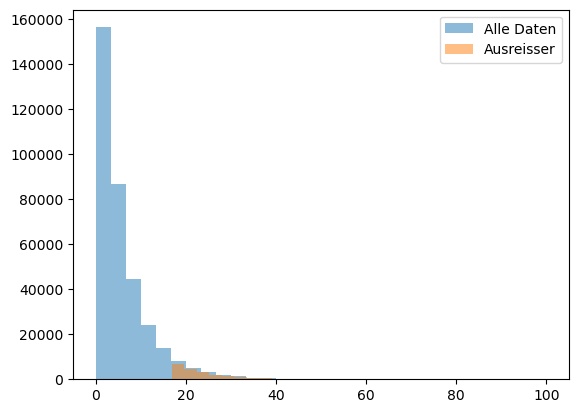

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%)
113586,7140112,"Oberwesel, Stadt",6 bis unter 15 Jahren,2019,26.416667,156.0,16.933761
268244,12062024,"Bad Liebenwerda, Stadt",0 bis unter 6 Jahren,2017,63.166667,373.0,16.934763
318031,15083320,Hötensleben,0 bis unter 6 Jahren,2017,26.25,155.0,16.935484
10986,1054121,Sönnebüll,6 bis unter 15 Jahren,2018,5.25,31.0,16.935484
54914,3359027,"Horneburg, Flecken",0 bis unter 6 Jahren,2017,57.75,341.0,16.935484
126802,7231041,Graach an der Mosel,6 bis unter 15 Jahren,2019,5.25,31.0,16.935484
40959,3251025,Marl,0 bis unter 6 Jahren,2018,5.25,31.0,16.935484
84668,6534004,"Biedenkopf, Stadt",0 bis unter 6 Jahren,2019,120.416667,711.0,16.93624
311903,14626350,"Neusalza-Spremberg, Stadt",6 bis unter 15 Jahren,2017,41.833333,247.0,16.936572
35344,3103000,"Wolfsburg, Stadt",0 bis unter 6 Jahren,2019,1128.5,6663.0,16.936815


In [180]:
# Histogramm der "SGB2-Quote (%)" Werte erstellen, das die Ausreisser hervorhebt
# Tabellenkopf mit den niedrigsten als Ausreissern identifizierten Werten anzeigen
plt.hist(stacked_lb_bev["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Alle Daten')
plt.hist(outliers["SGB2-Quote (%)"], bins=30, alpha=0.5, label='Ausreisser')
plt.legend(loc='upper right')
plt.show()
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)

#### ---> Identifikation auf Grundlage des IQR scheint nicht geeignet, da auch plausible Werte ab 18% als Ausreisser identifiziert werden...

In [181]:
# Alternative: Eigenen Schwellenwert bestimmen
threshold = 40
outliers = stacked_lb_bev[stacked_lb_bev["SGB2-Quote (%)"] > threshold]
num_outliers = len(outliers)
total_values = len(stacked_lb_bev)
outlier_percentage = (num_outliers / total_values) * 100
print("Prozentanteil der Ausreisser mit %-Werten ueber", threshold, "%:", outlier_percentage)
print("Anzahl der Ausreisser:", num_outliers)
outliers.sort_values('SGB2-Quote (%)', ascending=True).head(10)

Prozentanteil der Ausreisser mit %-Werten ueber 40 %: 0.2405949256342957
Anzahl der Ausreisser: 836


,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%)
149070,7333067,Schiersfeld,0 bis unter 6 Jahren,2021,4.0,10.0,40.0
148683,7333053,Oberhausen an der Appel,0 bis unter 6 Jahren,2018,2.0,5.0,40.0
102649,7134078,Schmißberg,0 bis unter 6 Jahren,2018,2.0,5.0,40.0
117799,7141087,Misselberg,15 bis unter 18 Jahren,2016,2.0,5.0,40.0
329317,16065018,Freienbessingen,0 bis unter 6 Jahren,2018,2.0,5.0,40.0
24358,1059075,"Schleswig, Stadt",6 bis unter 15 Jahren,2017,665.5,1663.0,40.01804
1913,1051071,Lunden,0 bis unter 6 Jahren,2015,36.833333,92.0,40.036232
298160,13075144,"Wolgast, Stadt",0 bis unter 6 Jahren,2017,274.083333,684.0,40.070663
9386,1054056,"Husum, Stadt",0 bis unter 6 Jahren,2018,382.75,955.0,40.078534
278789,12073309,Hohenselchow-Groß Pinnow,15 bis unter 18 Jahren,2018,8.416667,21.0,40.079365


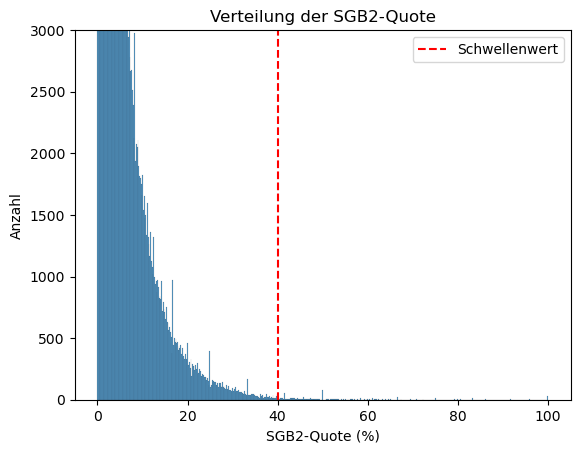

In [182]:
sns.histplot(stacked_lb_bev["SGB2-Quote (%)"])
plt.axvline(x=threshold, color='r', linestyle='--', label='Schwellenwert')
plt.legend()
plt.xlabel("SGB2-Quote (%)")
plt.ylabel("Anzahl")
plt.title("Verteilung der SGB2-Quote")
plt.ylim(0, 3000)
plt.show()

### 3.6 Moegliche bins fuer die Darstellung der Daten auf eingefaerbter Karte pruefen

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Das ist nuetzlich, wenn man will, dass die Farben auf der Karte gleichmaessig verteilt sind. Allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

Anm.: irgendwas laeuft bei der Berechnung falsch, die Bins sollten doch alle dieselbe Anzahl an Datenpunkten enthalten?!

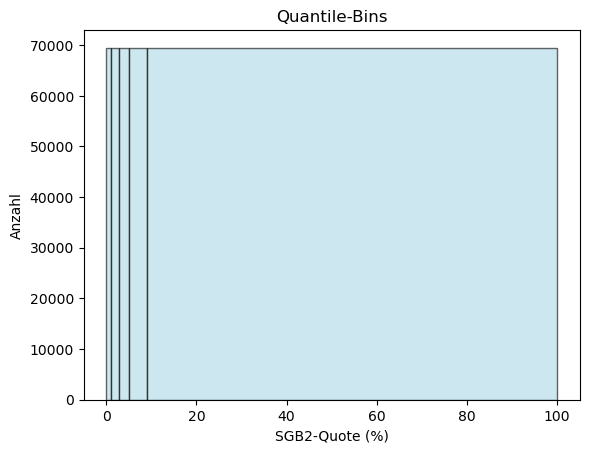

Bin 1: 0.00-1.09, Anzahl: 69495
Bin 2: 1.09-2.85, Anzahl: 69494
Bin 3: 2.85-5.06, Anzahl: 69488
Bin 4: 5.06-9.04, Anzahl: 69500
Bin 5: 9.04-100.00, Anzahl: 69464


In [183]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Das ist einfach zu verstehen und zu implementieren, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

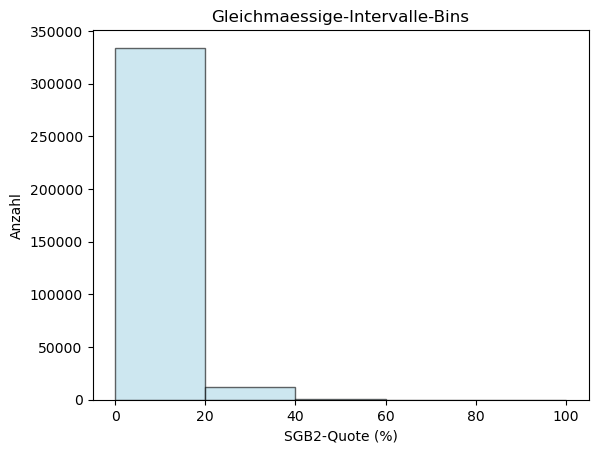

Bin 1: 0.00-20.00, Anzahl: 334127
Bin 2: 20.00-40.00, Anzahl: 12480
Bin 3: 40.00-60.00, Anzahl: 678
Bin 4: 60.00-80.00, Anzahl: 114
Bin 5: 80.00-100.00, Anzahl: 42


In [184]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev['SGB2-Quote (%)'].min(), stacked_lb_bev['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

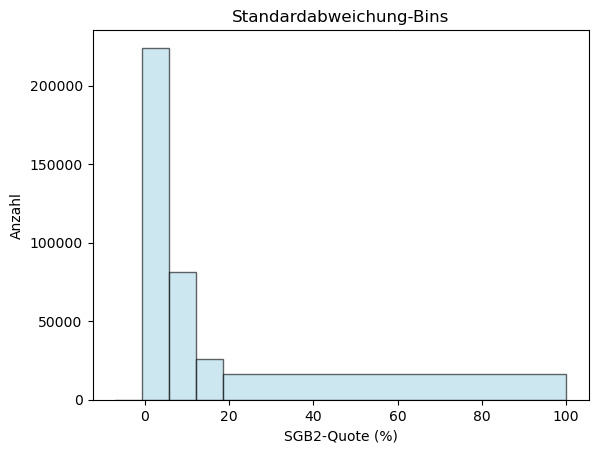

Bin 1: -7.10--0.69, Anzahl: 0
Bin 2: -0.69-5.72, Anzahl: 224204
Bin 3: 5.72-12.13, Anzahl: 81073
Bin 4: 12.13-18.54, Anzahl: 25879
Bin 5: 18.54-100.00, Anzahl: 16285


In [185]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev['SGB2-Quote (%)'].mean()
std = stacked_lb_bev['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc....

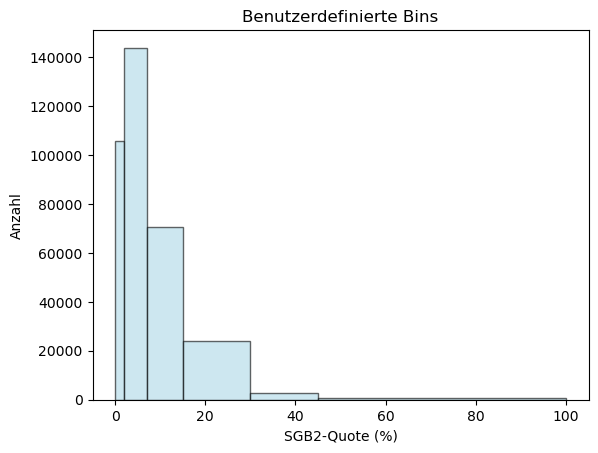

Bin 1: 0-2, Anzahl: 105623
Bin 2: 2-7, Anzahl: 143820
Bin 3: 7-15, Anzahl: 70734
Bin 4: 15-30, Anzahl: 24051
Bin 5: 30-45, Anzahl: 2729
Bin 6: 45-100, Anzahl: 484


In [186]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks Bins__:  Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren. Daher kann es sein, dass die unteren oder oberen Grenzen der Daten nicht beruecksichtigt werden, wenn sie nicht zu den natuerlichen "Bruechen" in den Daten beitragen (in unserem Fall an der unteren Grenze...)

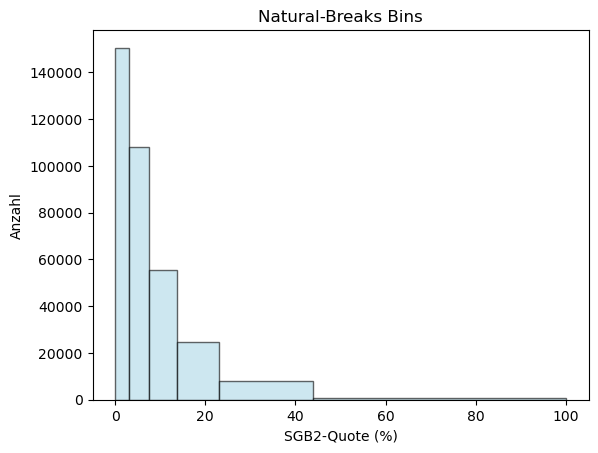

Bin 1: 0.0-3.158109209453953, Anzahl: 109188
Bin 2: 3.158109209453953-7.571684587813621, Anzahl: 108135
Bin 3: 7.571684587813621-13.694954605688265, Anzahl: 55627
Bin 4: 13.694954605688265-23.070418204182047, Anzahl: 24593
Bin 5: 23.070418204182047-44.00210502361041, Anzahl: 8085
Bin 6: 44.00210502361041-100.0, Anzahl: 558


In [187]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

__FisherJenksSampled__

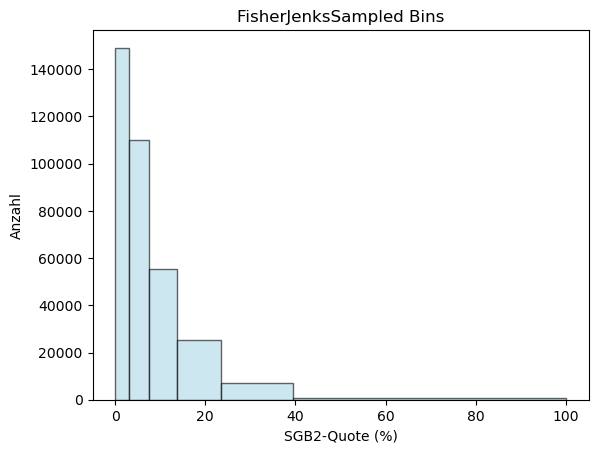

Bin 1: 0.0-3.125, Anzahl: 108144
Bin 2: 3.125-7.591093117408901, Anzahl: 109548
Bin 3: 7.591093117408901-13.690476190476192, Anzahl: 55226
Bin 4: 13.690476190476192-23.501642036124778, Anzahl: 25142
Bin 5: 23.501642036124778-39.473684210526365, Anzahl: 7214
Bin 6: 39.473684210526365-100.0, Anzahl: 912


In [188]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

In [189]:
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%)
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272


### 3.7 Testen, was passiert, wenn  alle Datenpunkte mit Bezugsgroeße > Grenzwert entfernt werden: Wieviel bleibt uebrig, wie wirkt es sich auf Verteilung und moegliche Bins aus?



In [190]:
# Datensaetze erstellen
stacked_lb_bev_ue100 = stacked_lb_bev[stacked_lb_bev.Anzahl_Bevoelkerung > 70]
stacked_elb_schul_ue100 = stacked_elb_schul[stacked_elb_schul.arbeitsuchende_elb_insgesamt > 70]
stacked_elb_beruf_ue100 = stacked_elb_beruf[stacked_elb_beruf.arbeitsuchende_elb_insgesamt > 70]

In [191]:
# Berechnen, welcher Anteil der Datenpunkte entfernt wurde
# (gibt einen Eindruck, wie viele "weiße Flecken" auf der Karte zu erwarten sind)

num_rows_stacked_elb_beruf = stacked_elb_beruf.shape[0]
num_rows_stacked_elb_schul = stacked_elb_schul.shape[0]
num_rows_stacked_lb_bev = stacked_lb_bev.shape[0]

num_rows_stacked_elb_beruf_ue100 = stacked_elb_beruf_ue100.shape[0]
num_rows_stacked_elb_schul_ue100 = stacked_elb_schul_ue100.shape[0]
num_rows_stacked_lb_bev_ue100 = stacked_lb_bev_ue100.shape[0]

diff1 = num_rows_stacked_elb_beruf - num_rows_stacked_elb_beruf_ue100
diff2 = num_rows_stacked_elb_schul - num_rows_stacked_elb_schul_ue100
diff3 = num_rows_stacked_lb_bev - num_rows_stacked_lb_bev_ue100

remaining1 = num_rows_stacked_elb_beruf_ue100/num_rows_stacked_elb_beruf*100
remaining2 = num_rows_stacked_elb_schul_ue100/num_rows_stacked_elb_schul*100
remaining3 = num_rows_stacked_lb_bev_ue100/num_rows_stacked_lb_bev*100

print("In der Tabelle 'stacked_elb_beruf' wurden", diff1, "Datenpunkte entfernt. Es sind noch", remaining1, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_elb_schul' wurden", diff2, "Datenpunkte entfernt. Es sind noch", remaining2, "% der Ausgangswerte enthalten." )
print("In der Tabelle 'stacked_lb_bev' wurden", diff3, "Datenpunkte entfernt. Es sind noch", remaining3, "% der Ausgangswerte enthalten." )


In der Tabelle 'stacked_elb_beruf' wurden 247296 Datenpunkte entfernt. Es sind noch 27.99021606196494 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_elb_schul' wurden 370944 Datenpunkte entfernt. Es sind noch 27.99021606196494 % der Ausgangswerte enthalten.
In der Tabelle 'stacked_lb_bev' wurden 116172 Datenpunkte entfernt. Es sind noch 66.5665147119768 % der Ausgangswerte enthalten.


#### --> kann nicht die Loesung sein, es gehen zu viele Werte verloren...

__Quantile-Methode__: Bei dieser Methode werden die Bins so gewaehlt, dass jedes Intervall die gleiche Anzahl von Datenpunkten enthaelt. Das ist nuetzlich, wenn man will, dass die Farben auf der Karte gleichmaessig verteilt sind. Allerdings koennen kleine Unterschiede in den Daten zu grossen Unterschieden in den Bins fuehren, wenn die Daten eng beieinander liegen.

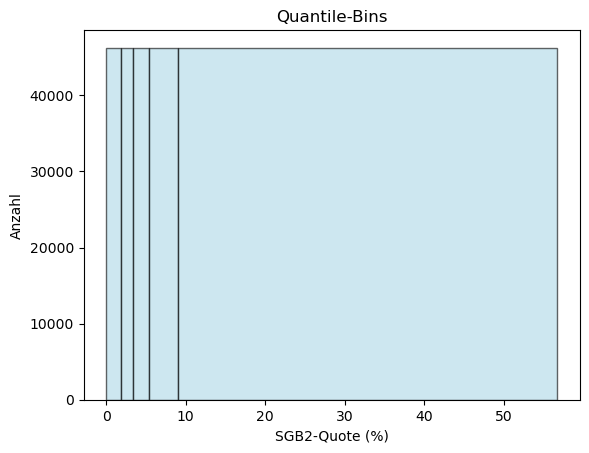

Bin 1: 0.00-1.82, Anzahl: 46260
Bin 2: 1.82-3.32, Anzahl: 46260
Bin 3: 3.32-5.35, Anzahl: 46260
Bin 4: 5.35-9.07, Anzahl: 46260
Bin 5: 9.07-56.68, Anzahl: 46259


In [192]:
# Anzahl der Bins
num_bins = 5

# Quantile berechnen
quantiles = np.linspace(0, 1, num_bins + 1)
bin_edges = np.quantile(stacked_lb_bev_ue100['SGB2-Quote (%)'], quantiles)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Quantile-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Gleichmaessige Intervalle__: Hierbei wird der gesamte Bereich der Daten in gleich grosse Intervalle unterteilt. Das ist einfach zu verstehen und zu implementieren, kann jedoch dazu fuehren, dass viele Datenpunkte in ein oder zwei Bins fallen, wenn die Daten stark ungleich verteilt sind.

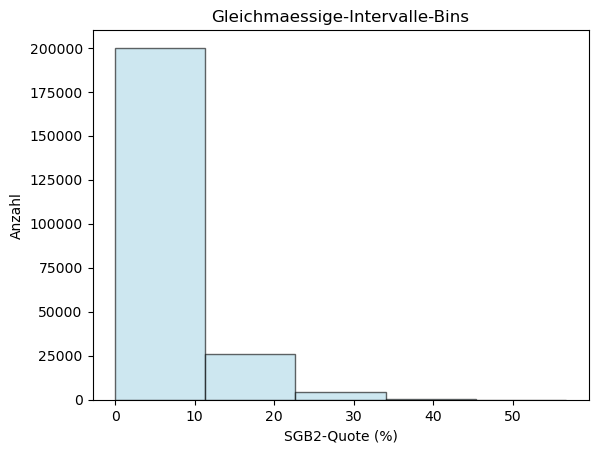

Bin 1: 0.00-11.34, Anzahl: 200049
Bin 2: 11.34-22.67, Anzahl: 26101
Bin 3: 22.67-34.01, Anzahl: 4556
Bin 4: 34.01-45.34, Anzahl: 547
Bin 5: 45.34-56.68, Anzahl: 46


In [193]:
# Anzahl der Bins
num_bins = 5

# Gleichmaessige Intervalle berechnen
bin_edges = np.linspace(stacked_lb_bev_ue100['SGB2-Quote (%)'].min(), stacked_lb_bev_ue100['SGB2-Quote (%)'].max(), num_bins + 1)

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Gleichmaessige-Intervalle-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(num_bins):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Standardabweichung__: Hierbei werden Bins basierend auf der statistischen Standardabweichung der Daten erstellt. Dies kann hilfreich sein, um zu sehen, welche Datenpunkte signifikant vom Durchschnitt abweichen.

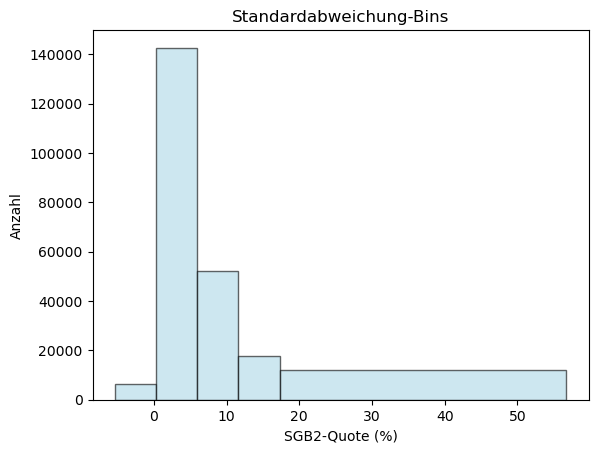

Bin 1: -5.34-0.32, Anzahl: 6538
Bin 2: 0.32-5.98, Anzahl: 142734
Bin 3: 5.98-11.63, Anzahl: 52267
Bin 4: 11.63-17.29, Anzahl: 17701
Bin 5: 17.29-56.68, Anzahl: 12059


In [194]:
# Anzahl der Bins
num_bins = 5

# Standardabweichung berechnen
mean = stacked_lb_bev_ue100['SGB2-Quote (%)'].mean()
std = stacked_lb_bev_ue100['SGB2-Quote (%)'].std()
bin_edges = [mean - 2*std, mean - std, mean, mean + std, mean + 2*std, stacked_lb_bev_ue100['SGB2-Quote (%)'].max()]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bin_edges, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Standardabweichung-Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(bin_edges)-1):
    bin_range = f'{bin_edges[i]:.2f}-{bin_edges[i+1]:.2f}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= bin_edges[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < bin_edges[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Benutzerdefinierte Bins__:  Hier kann der Benutzer die Bins manuell festlegen, auf Grundlage seines Wissens ueber die Struktur der Daten, fachlicher Erwaegungen, seiner Anforderungen an die Visualisierung etc....

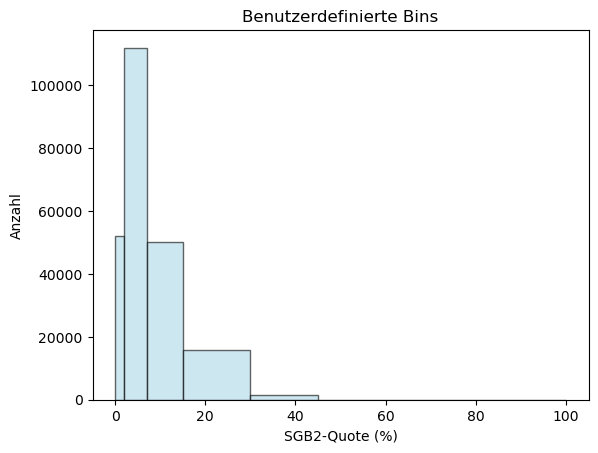

Bin 1: 0-2, Anzahl: 52137
Bin 2: 2-7, Anzahl: 111876
Bin 3: 7-15, Anzahl: 50036
Bin 4: 15-30, Anzahl: 15810
Bin 5: 30-45, Anzahl: 1390
Bin 6: 45-100, Anzahl: 51


In [195]:
# Benutzerdefinierte Bins festlegen
custom_bins = [0, 2, 7, 15, 30, 45, 100]

# Histogramm erstellen
plt.hist(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=custom_bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Benutzerdefinierte Bins')
plt.show()

# Bins und Anzahl der Werte ausgeben
for i in range(len(custom_bins)-1):
    bin_range = f'{custom_bins[i]}-{custom_bins[i+1]}'
    count = ((stacked_lb_bev_ue100['SGB2-Quote (%)'] >= custom_bins[i]) & (stacked_lb_bev_ue100['SGB2-Quote (%)'] < custom_bins[i+1])).sum()
    print(f'Bin {i+1}: {bin_range}, Anzahl: {count}')

__Natural-Breaks Bins__: Die Methode Natural Breaks klassifiziert die Datenpunkte in Klassen basierend auf natuerlichen Gruppen in den Daten selbst. Sie versucht, die Varianz innerhalb der Gruppen zu minimieren und die Varianz zwischen den Gruppen zu maximieren. Daher kann es sein, dass die unteren oder oberen Grenzen der Daten nicht beruecksichtigt werden, wenn sie nicht zu den natuerlichen "Bruechen" in den Daten beitragen (in diesem Fall an der unteren Grenze...)

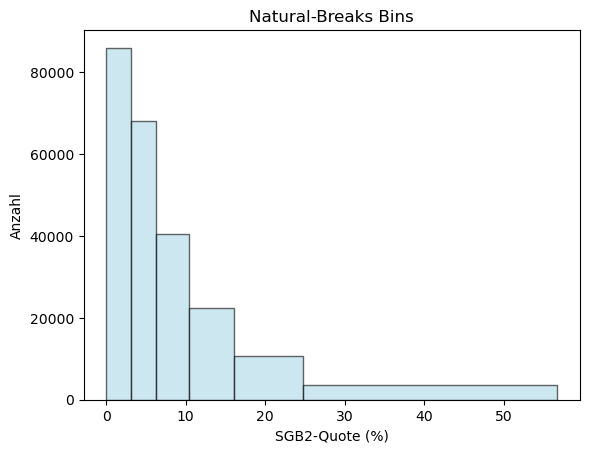

Bin 1: 0.0-3.093467870419541, Anzahl: 82502
Bin 2: 3.093467870419541-6.277974087161365, Anzahl: 68155
Bin 3: 6.277974087161365-10.398668106551474, Anzahl: 40442
Bin 4: 10.398668106551474-16.12426035502959, Anzahl: 22309
Bin 5: 16.12426035502959-24.697916666666714, Anzahl: 10777
Bin 6: 24.697916666666714-56.67892156862743, Anzahl: 3690


In [196]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue100['SGB2-Quote (%)'].values

# Berechnen der Bins mit der NaturalBreaks-Methode
classifier = NaturalBreaks(data, k=6)
breaks = classifier.bins
breaks = np.insert(breaks, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=breaks, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('Natural-Breaks Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(breaks)-1):
    print(f"Bin {i+1}: {breaks[i]}-{breaks[i+1]}, Anzahl: {((data > breaks[i]) & (data <= breaks[i+1])).sum()}")

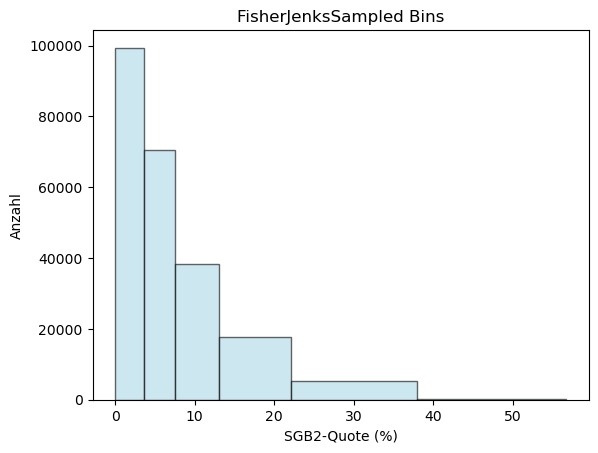

Bin 1: 0.0-3.5788381742738586, Anzahl: 95957
Bin 2: 3.5788381742738586-7.476635514018691, Anzahl: 70408
Bin 3: 7.476635514018691-13.126361655773417, Anzahl: 38178
Bin 4: 13.126361655773417-22.112430020625506, Anzahl: 17698
Bin 5: 22.112430020625506-37.89899536786378, Anzahl: 5390
Bin 6: 37.89899536786378-56.67892156862743, Anzahl: 244


In [197]:
# Extrahieren der Werte aus der Spalte 'SGB2-Quote (%)'
data = stacked_lb_bev_ue100['SGB2-Quote (%)'].values

# Berechnen der Bins mit der FisherJenksSampled-Methode
classifier = FisherJenksSampled(data, pct=0.2, k=6)
bins = classifier.bins
bins = np.insert(bins, 0, 0)

# Erstellen des Histogramms
plt.hist(data, bins=bins, edgecolor='black', color='lightblue', alpha=0.6)
plt.xlabel('SGB2-Quote (%)')
plt.ylabel('Anzahl')
plt.title('FisherJenksSampled Bins')
plt.show()

# Ausgabe der Bin-Ranges und der Anzahl der Werte in jedem Bin
for i in range(len(bins)-1):
    print(f"Bin {i+1}: {bins[i]}-{bins[i+1]}, Anzahl: {((data > bins[i]) & (data <= bins[i+1])).sum()}")

In [198]:
classifier

FisherJenksSampled

   Interval      Count
----------------------
[ 0.00,  3.58] | 99382
( 3.58,  7.48] | 70408
( 7.48, 13.13] | 38178
(13.13, 22.11] | 17698
(22.11, 37.90] |  5390
(37.90, 56.68] |   244

In [199]:
bins

array([ 0.        ,  3.57883817,  7.47663551, 13.12636166, 22.11243002,
       37.89899537, 56.67892157])

In [200]:
bins = np.insert(bins, 0, 0)
bins

array([ 0.        ,  0.        ,  3.57883817,  7.47663551, 13.12636166,
       22.11243002, 37.89899537, 56.67892157])

### Bins-Spalte ergänzen

In [201]:
# Grenzen und Labels für die Bins (basierend auf FisherJenks) definieren
bins = [0, 3, 7.81, 14.81, 25.99, 58.33, 100]
labels = [1, 2, 3, 4, 5, 6]

# neue 'bins'-Spalte erstellen
stacked_lb_bev['bins'] = pd.cut(stacked_lb_bev['SGB2-Quote (%)'], bins=bins, labels=labels)

stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,4
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028,4
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869,5
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344,5
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272,5


In [202]:
# Grenzen und Labels für die Bins (basierend auf FisherJenks) definieren
bins = [0, 3.4, 7.8, 13.7, 21.8, 40.4, 100]
labels = [1, 2, 3, 4, 5, 6]

# neue 'bins'-Spalte erstellen
stacked_lb_bev_ue100['bins'] = pd.cut(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bins, labels=labels)

stacked_lb_bev_ue100.head()

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\1646345990.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100['bins'] = pd.cut(stacked_lb_bev_ue100['SGB2-Quote (%)'], bins=bins, labels=labels)


,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,5
1,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028,5
2,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869,5
3,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344,5
4,1001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272,5


### Problem beheben, dass durch 7-stellige AGS entsteht
erstmal nur mit SGB-II Tabelle testen

In [203]:
# Spalte "AGS" als String definieren
stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].astype(str)

# "0" vor den Einträgen mit genau 7 Zeichen hinzufügen
stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\3310119617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].astype(str)
C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\3310119617.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100["AGS"] = stacked_lb_bev_ue100["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)


In [204]:
# Spalte "AGS" als String definieren
stacked_lb_bev["AGS"] = stacked_lb_bev["AGS"].astype(str)

# "0" vor den Einträgen mit genau 7 Zeichen hinzufügen
stacked_lb_bev["AGS"] = stacked_lb_bev["AGS"].apply(lambda x: '0' + x if len(x) == 7 else x)

In [205]:
# Prüfen, ob alles funktioniert hat:

# Filtern des DataFrames nach Zeilen, in denen die Länge der Spalte "AGS" genau 7 ist
filtered_df = stacked_lb_bev[stacked_lb_bev["AGS"].str.len() == 7]

# Zählen der Anzahl von Zeilen im gefilterten DataFrame
count = len(filtered_df)

# Ausgabe der Anzahl
print(count)

0


In [206]:
stacked_lb_bev.head()

,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,4
1,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028,4
2,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869,5
3,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344,5
4,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272,5


### AGS für Kreisebene ergänzen

In [207]:
stacked_lb_bev_ue100['AGS_Kreis'] = stacked_lb_bev_ue100['AGS'].str[:5]
stacked_lb_bev_ue100.head()

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\2970265749.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100['AGS_Kreis'] = stacked_lb_bev_ue100['AGS'].str[:5]


,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins,AGS_Kreis
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,5,01001
1,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028,5,01001
2,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869,5,01001
3,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344,5,01001
4,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272,5,01001


### AGS für Bundesland ergänzen

In [208]:
stacked_lb_bev_ue100['AGS_BL'] = stacked_lb_bev_ue100['AGS'].str[:2]
stacked_lb_bev_ue100.head()

C:\Users\tobias.vetterle\AppData\Local\Temp\ipykernel_9792\2599422396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stacked_lb_bev_ue100['AGS_BL'] = stacked_lb_bev_ue100['AGS'].str[:2]


,AGS,Gemeinde,Altersgruppe_LB,Jahr,Anzahl_LB,Anzahl_Bevoelkerung,SGB2-Quote (%),bins,AGS_Kreis,AGS_BL
0,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2014,1055.5,4303.0,24.529398,5,01001,01
1,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2015,1115.166667,4303.0,25.916028,5,01001,01
2,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2016,1136.416667,4303.0,26.409869,5,01001,01
3,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2017,1325.166667,4303.0,30.796344,5,01001,01
4,01001000,"Flensburg, Stadt",0 bis unter 6 Jahren,2018,1446.25,4303.0,33.610272,5,01001,01


### 4. Tabellen exportieren als Excel und CSV

In [209]:
# DataFrame stacked_elb_schul speichern
stacked_elb_schul.to_excel('elb_quote_schul.xlsx', index=False)
stacked_elb_schul.to_csv('elb_quote_schul.csv', index=False)

stacked_elb_schul_ue100.to_excel('elb_quote_schul_ue100.xlsx', index=False)
stacked_elb_schul_ue100.to_csv('elb_quote_schul_ue100.csv', index=False)

# DataFrame stacked_elb_beruf speichern
stacked_elb_beruf.to_excel('elb_quote_beruf.xlsx', index=False)
stacked_elb_beruf.to_csv('elb_quote_beruf.csv', index=False)

stacked_elb_beruf_ue100.to_excel('elb_quote_beruf_ue100.xlsx', index=False)
stacked_elb_beruf_ue100.to_csv('elb_quote_beruf_ue100.csv', index=False)

# DataFrame stacked_lb_bev speichern
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)
stacked_lb_bev.to_csv('sgb2_quote.csv', index=False)

stacked_lb_bev_ue100.to_excel('sgb2_quote_ue100.xlsx', index=False)
stacked_lb_bev_ue100.to_csv('sgb2_quote_ue100.csv', index=False)

In [210]:
stacked_lb_bev["SGB2-Quote (%)"].describe()

count     347472.0
unique    189053.0
top            0.0
freq       41286.0
Name: SGB2-Quote (%), dtype: float64

In [211]:
stacked_lb_bev.to_excel('sgb2_quote.xlsx', index=False)


In [212]:
stacked_lb_bev_ue100.to_excel('sgb2_quote_ue100.xlsx', index=False)
